# Transfer Learning Strategies

You have seen how to load and use pre-trained models from TorchVision for straightforward image classification. These models, trained on vast datasets like ImageNet, are experts in their domain. But what happens when you need to solve a problem outside of that domain? An expert in identifying animals and cars may be completely lost when asked to recognize handwritten digits. This lab confronts that exact challenge, showing how a powerful model can fail on a seemingly simple, out-of-domain task.

This scenario highlights the need for **transfer learning**, a powerful technique for adapting a model's existing knowledge to your specific needs. Instead of training a network from scratch, you'll leverage a model's pre-trained **feature extractor**, the layers that have learned to recognize universal patterns like edges and textures. You'll then replace the model's original **classifier head** with a new one tailored to your task. The key decision is determining how much of the original model to retrain, which can range from updating only the new classifier to fine-tuning the entire network. This flexible approach saves significant training time and computational resources, making it a vital skill for any deep learning practitioner.

In this lab, you will put theory into practice. You will:

* Witness the limitations of a pre-trained model when faced with a new, specialized dataset.

* Learn to modify the architecture of pre-trained models by replacing their final classification layer, exploring two common patterns: Direct Attribute access and Modular Block access.

* Implement and compare three distinct transfer learning strategies, each offering a different balance of speed and performance:
    * **Feature Extraction**: Freezing the model's backbone and training only the new classifier head.
    
    * **Fine-Tuning**: Unfreezing and training the top layers of the backbone for better adaptation.
    
    * **Full Retraining**: Training the entire model end-to-end for maximum performance.

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.models as tv_models
import torchvision.transforms as transforms

import helper_utils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


## When Expertise Is Not Enough: The Limits of Pre-trained Models

As you saw in the previous lab, pre-trained models are incredibly powerful. They offer a phenomenal head start, providing expert level knowledge learned from massive datasets like ImageNet. For tasks that align with their original training, such as identifying common objects in photographs, they perform brilliantly right out of the box.

Let's explore this with a simple but revealing experiment. A model like [MobileNetV3](https://docs.pytorch.org/vision/main/models/mobilenetv3.html) is a certified expert, trained to identify a 1000 different classes of objects with high accuracy. It can distinguish between a 'sports car' and a 'race car'. But what happens when you ask this expert to perform a task that seems much simpler, like recognizing basic handwritten numbers and letters?

To find out, you will challenge the model with the `EMNIST` dataset of handwritten digits. Although this is a straightforward dataset, it perfectly simulates a common and vital real world problem: **what do you do when a pre-trained model, for all its power, has no knowledge of the specific classes your project requires?** This is a situation you will frequently encounter, and the principle you are about to see applies to any custom task, no matter how complex.

* Define the transformation pipeline for the `EMNIST` dataset. Since the dataset is simple, you can use the same for both, training and validation datasets. 

* Remember, when using a pre-trained model, it is an essential practice to format your input data to match the configuration the model was originally trained on. A mismatch can lead to poor performance or errors.

In [3]:
# Define the transformation pipeline
emnist_transformation = transforms.Compose([
    # Convert grayscale image to 3 channels to match MobileNetV2's input
    transforms.Grayscale(num_output_channels=3),
    # Resize the image to 224x224, the standard input size for MobileNetV2
    transforms.Resize((224, 224)),
    # Apply the 90-degree rotation augmentation
    transforms.RandomRotation(degrees=(90, 90)),
    # Apply the vertical flip augmentation
    transforms.RandomVerticalFlip(p=1.0),
    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),
    # Normalize the tensor using ImageNet's mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


* Next, create the training and validation data loaders from the `EMNIST` dataset's `digits` split, applying the transformation pipeline you just defined.

In [4]:
# Create the training and validation DataLoaders.
train_loader, val_loader = helper_utils.create_emnist_dataloaders(
    batch_size=32,
    transform=emnist_transformation  # Apply the defined transformations
)

* Load the `MobileNetV3` Small model with its `'IMAGENET1K_V1'` pre-trained weights and set it to evaluation mode using `.eval()`.

In [5]:
# Load the pre-trained MobileNetV3 model and set it to evaluation mode for inference
mobilenet_model = tv_models.mobilenet_v3_small(weights='IMAGENET1K_V1').eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/jovyan/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 112MB/s]


* Since you already know this model was trained on the standard ImageNet dataset, you can take a shortcut and load the 1,000 class names directly from `./imagenet_class_index.json`, the same file you used in the previous lab.

In [6]:
# Load the mapping of class indices to human-readable names from the JSON file
class_names = helper_utils.load_imagenet_classes('./imagenet_class_index.json')

Loading ImageNet class index from: ./imagenet_class_index.json
Successfully loaded the class index.


<br>

* Now for the moment of truth: pass the model and data loader to the helper function to visualize the model's predictions on these unfamiliar images.

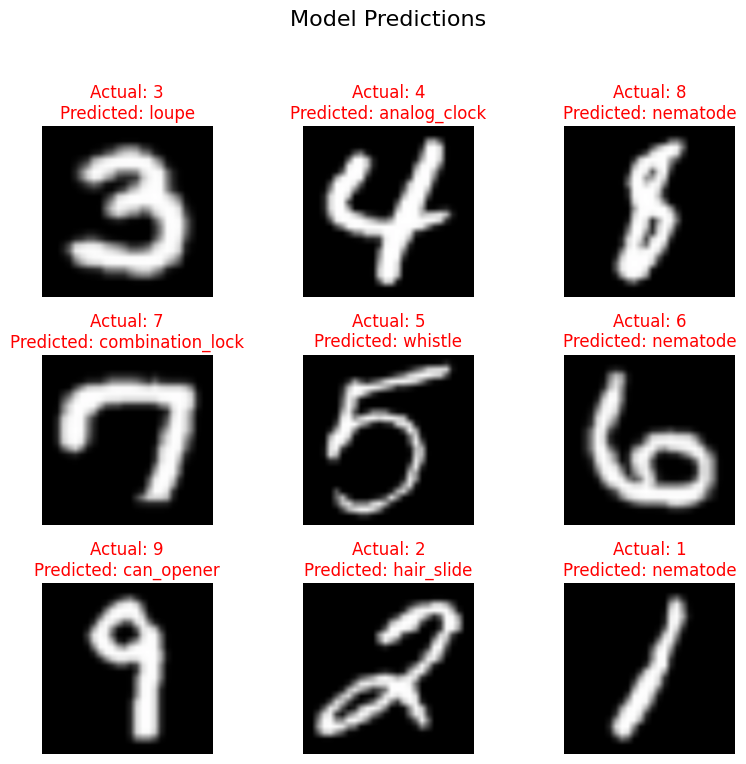

In [7]:
# Visualize the model's predictions on the validation images
helper_utils.show_predictions(mobilenet_model, val_loader, device, class_names)

<br>

Well, that's surprising. A model smart enough to identify 1,000 different objects looks at these numbers and sees a spatula or a nematode, among other things. It seems that the model has a very active imagination! 

As you can see, the predictions are not just slightly off; they are completely out of context. This happens because the model is doing its best to match these unfamiliar shapes to the closest visual patterns it learned from its ImageNet training. It has no concept of numbers, so it finds the next best thing in its vocabulary.

This perfectly illustrates the core problem: a pre-trained model's knowledge is powerful but limited to its original domain. So, how do you teach an expert model a new skill? The solution is a powerful technique called **transfer learning**. In the next section, you'll learn how to take this model's existing knowledge and adapt it to correctly identify the very numbers it just failed to recognize.

## Transfer Learning

Using a pre-trained model for inference is powerful, but its true potential is unlocked when you adapt it for a new, custom task. This process, called **transfer learning**, allows you to leverage a model's expert knowledge of general shapes and patterns to achieve excellent results on your specific dataset with significantly less data and training time.

The core idea is to treat the pre-trained model as two distinct parts:

* The **Feature Extractor** (or "backbone"): These are the early layers of the network that have learned to recognize universal visual features like edges, textures, and shapes.

* The **Classifier Head**: This is the final layer (or layers) that takes the features from the backbone and makes the final prediction.

In transfer learning, you will always replace the original classifier head with a new one designed for your specific number of classes. The main question then becomes: **how much of the feature extractor should you train?** This choice gives rise to three primary strategies, each offering a different trade off between training time and performance. You will see these strategies in action.

### Strategy 1: Feature Extraction (Train Only the New Head)

This is the fastest and most computationally efficient approach. You **freeze** the entire backbone and only train the new classifier head. You are effectively using the pre-trained model as a fixed feature extractor, trusting its existing knowledge completely. This is an excellent starting point, especially when your dataset is small.

While this strategy focuses on training *only* the classifier head, the practical skill of identifying and replacing it is a foundational step for **any** transfer learning approach you will use. The exact method depends on the model's architecture, which typically follows one of two patterns: a **Direct Attribute** (like in ResNet) or a **Modular Block** (like in MobileNet). You will now explore both, starting with the Direct Attribute pattern.

#### Direct Attribute

Let's start with the Direct Attribute pattern. For this, you'll use [ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

* From the [weights of this particular model](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights), you’ll use `IMAGENET1K_V1`. 
* Next, you load the `ResNet18` model with these specified weights.

In [8]:
# Instantiate the ResNet18 model architecture and load the selected weights
resnet18_model = tv_models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


* Now, inspect the model's architecture.
* To do this, you can print the entire model. The output will be verbose as it lists every layer in the network. 

```
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  ...
    
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)
```

In [9]:
### Uncomment and execute the line below if you wish print the model's architecture.

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<br>

**Note these key architectural details that inform how you'll modify the model.**

* Notice how all the main components (`conv1`, `layer1`, `fc`, etc.) are direct attributes of the main `ResNet` model. There isn't a single, high-level block called `features` that groups all the convolutional layers together. This "flat" structure tells you that the simplest approach to freeze all parameters at once is with a single loop over the model's parameters (`resnet18_model.parameters()`).

* In transfer learning, you always replace the model's final **classifier head**. By inspecting the end of the output, you can identify the final layer, which is a `Linear` layer named `fc`.

* `out_features=1000`: Corresponds to the original ImageNet classes. You will replace this layer to match the number of classes for your new task.

Now that you understand the model's architecture, begin by **freezing** the layers of the pre-trained model. This step ensures that the model retains the valuable features it learned from its initial training.

* Iterate over each parameter in `resnet18_model` using `resnet18_model.parameters()`.
* For each `param`, set `param.requires_grad=False`. This prevents gradients from being computed for these parameters during fine-tuning the model for your specific task, effectively freezing their weights.

In [10]:
# Iterate over each parameter in the resnet18_model
for param in resnet18_model.parameters():
    # Set the requires_grad attribute of each parameter to False to freeze it
    param.requires_grad = False

* After freezing the earlier layers, the next step is to modify the **classifier head** to suit your new task. As identified earlier, for `ResNet18`, this is the `fc` (fully connected) layer.

In [11]:
# Access the fully connected layer (fc) of the resnet18_model
original_fc_layer = resnet18_model.fc

print("Model's Original Fully Connected Layer:")
print(original_fc_layer)

Model's Original Fully Connected Layer:
Linear(in_features=512, out_features=1000, bias=True)


<br>

* The final step is to replace model's original classifier head with a new one tailored for your specific classification task. Let's assume, for your new task, the number of classes you want is `5`.
    
    * `num_features = original_fc_layer.in_features`: This retrieves the **input feature dimension** of the original `fc` layer (`in_features=512`). This value represents the output size of the pre-trained feature extractor layers, and your new classifier **must** be able to accept inputs of this size.
    
    * `num_classes=5`: Here, you define the number of classes for your new task.
    
    * `new_fc_layer = nn.Linear(in_features=num_features, out_features=num_classes)`: A new `Linear` (fully connected) layer is created. It's configured to accept the `num_features` from the frozen backbone and output a prediction for each of your `num_classes`.
    
    * `resnet18_model.fc = new_fc_layer`: This is where the replacement happens! You directly assign your `new_fc_layer` to the `fc` attribute of the `resnet18_model`, effectively swapping out the old ImageNet classifier for your custom one.

In [12]:
# Get the number of input features to the original fully connected layer
# This is stored in the 'in_features' attribute of the linear layer
num_features = original_fc_layer.in_features

# Define the number of output classes for the new classification task
num_classes = 5

# Create a new fully connected layer (Linear layer)
new_fc_layer = nn.Linear(in_features=num_features, out_features=num_classes)

# Replace the original fully connected layer of resnet18_model with the new_fc_layer
resnet18_model.fc = new_fc_layer

print("Model's New Fully Connected Layer:")
print(resnet18_model.fc)

Model's New Fully Connected Layer:
Linear(in_features=512, out_features=5, bias=True)


<br>

And with that, you have successfully reconfigured the `ResNet` model for a new task! This process, freezing the feature extractor and swapping the classifier, is a cornerstone of transfer learning. You are now ready to apply this same core principle to the next common architectural pattern: the Modular Block.

#### Modular Block

Now let's look at the Modular Block pattern. For this, you'll use [MobileNetV3](https://docs.pytorch.org/vision/main/models/mobilenetv3.html) Small.

* From the [weights of this particular model](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights), you’ll use `IMAGENET1K_V1`.
* Next, you load the `MobileNetV3` Small model with these specified weights.

In [13]:
# Instantiate the MobileNetV3 Small architecture and load the selected weights
mobilenet_model = tv_models.mobilenet_v3_small(weights='IMAGENET1K_V1')

* Now, inspect the model's architecture.
* To do this, you can print the entire model. The output will be verbose as it lists every layer in the network. 

```
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
 ...
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=1024, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=1000, bias=True)
  )
)
```


In [14]:
### Uncomment and execute the line below if you wish to print the model's architecture.

print(mobilenet_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

<br>

**Note these key architectural details that inform how you'll modify the model.**

* **Notice the modular structure**: The convolutional layers are grouped within a `Sequential` block named `features`, and the final prediction layers are contained within **another** `Sequential` block named `classifier`. This modularity means you'll freeze parameters by iterating over the parameters within the features (`mobilenet_model.features.parameters()`) for the backbone and specifically target the classifier (`mobilenet_model.classifier`) for modification.

* By inspecting the end of the output, you can identify the final classification layer as the **last** `Linear` layer (labeled `(3)`) inside the `classifier` `Sequential` block.

* `out_features=1000`: Corresponds to the original ImageNet classes. You will replace this layer to match the number of classes for your new task.

<br>

Same as before, you'll **freeze** the earlier layers. However, due to `MobileNetV3` Small's modular structure, you'll specifically target its `features` block.

* Iterate over each parameter in `mobilenet_model.features` using `mobilenet_model.features.parameters()`.
* For each `feature_parameter`, `set feature_parameter.requires_grad = False`. 

In [15]:
# Iterate through each parameter in model.features.parameters()
for feature_parameter in mobilenet_model.features.parameters():
    # Set the requires_grad attribute of each feature_parameter to False
    feature_parameter.requires_grad = False

As before, the next step is to modify the classifier head. Unlike ResNet's direct `fc` attribute, `MobileNetV3`'s classifier is a `Sequential` block. 

* To access the final linear layer within this block (which performs the actual classification), use `mobilenet_model.classifier[-1]` to directly select the last element in the `classifier`'s sequence of layers.

In [16]:
# Access the final classification layer of the model
last_classifier_layer = mobilenet_model.classifier[-1]

print("Model's Original Output Layer:")
print(last_classifier_layer)

Model's Original Output Layer:
Linear(in_features=1024, out_features=1000, bias=True)


<br>

Same as before, the final step is to replace the model's original classifier head with a new one tailored for your specific classification task. Let's assume your new task requires `10` classes. Everything happens the same, except:

* `mobilenet_model.classifier[-1]=new_classifier`: Since the classifier is a Sequential block, you directly assign your `new_classifier` to the last element (`[-1]`) of `mobilenet_model.classifier`, effectively swapping out the old ImageNet classifier for your custom one. This new layer will be the only part of the model that learns during fine-tuning.

In [17]:
# Access the in_features attribute of last_classifier_layer
num_features = last_classifier_layer.in_features

# Define the number of output classes for the new classification task
num_classes = 10

# Create a new Linear layer for classification
new_classifier = nn.Linear(in_features=num_features, out_features=num_classes)

# Replace the original last classification layer with the newly created layer
mobilenet_model.classifier[-1] = new_classifier

print("Model's New Output Layer:")
print(mobilenet_model.classifier[-1])

Model's New Output Layer:
Linear(in_features=1024, out_features=10, bias=True)


<br>

And that's how you prepare a model for transfer learning when it has a modular architecture!

#### Training the Classifier Head

It's time to put **Strategy 1 (Feature Extraction)** into practice by solving the initial `EMNIST` challenge. You will use the `mobilenet_model` you already prepared; its new 10-class classifier head is a perfect match for the 10 digit classes in the `EMNIST` dataset. Since the model and data loaders are ready, the first step is to define the loss function and optimizer.

* Define the loss function and optimizer.
* `filter(lambda p: p.requires_grad, mobilenet_model.parameters()`: Notice that you are **only** passing the parameters of the new *classifier head* to the optimizer.
    * This selects only the model parameters that require gradients (i.e., are not frozen). This ensures that you exclusively train the new, final layer for your specific task, which is the central principle of this feature extraction approach.

In [18]:
# Define loss and optimizer
loss_function = torch.nn.CrossEntropyLoss()
# Only optimize the parameters that require gradients for mobilenet_model
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   mobilenet_model.parameters()),
                            lr=0.001)

* Finally, pass all the components, the model, data loaders, loss function, and optimizer to the `training_loop` function to start the training.

In [19]:
# Number of epochs for new classifier head training
num_epochs = 1

# Start the training.
trained_model = helper_utils.training_loop(
    model=mobilenet_model, 
    trainloader=train_loader, 
    valloader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    device=device
)

Epoch 1/1 [Train]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]


Finished Training!
Final Validation Accuracy: 0.8175


<br>

With just a single epoch of training, the model achieved an impressive validation accuracy of over 80%.

* Now, visualize the model's new predictions to see this improved performance in action.
    * Since you replaced the model's original classifier head with one trained on `EMNIST` digits, the old ImageNet class names are no longer valid.

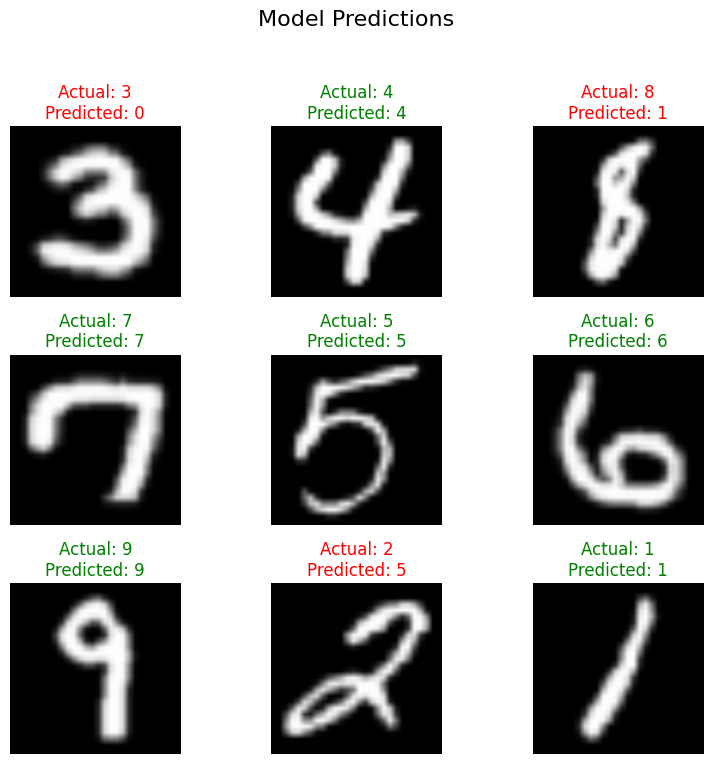

In [20]:
# Define a list of class names for the EMNIST digits (0-9).
emnist_class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Visualize the model's predictions on the validation images
helper_utils.show_predictions(trained_model, val_loader, device, emnist_class_names)

<br>

As you've seen, training only the classifier head is a fast and effective way to get strong initial results. However, to push your model's performance even further, you can move beyond simple feature extraction and begin to fine-tune the backbone itself. This leads to the second, more powerful strategy.

### Strategy 2: Fine-Tuning (Train the Head and Top Layers)

This highly effective and popular strategy serves as a middle ground, offering better performance than feature extraction without the cost of retraining the entire model. When you decide to fine-tune, you have two primary options:

* **Single Stage Training**: A straightforward approach where you unfreeze the desired top layers of the backbone and train them simultaneously with the new classifier head, typically using a single learning rate.

* **Two Stage Training**: A more careful and often more effective approach that separates the training process into two distinct stages to gently adapt the model.

    The two stage strategy works as follows:

    * **Stage 1 (Train the Head)**: You begin exactly as you did in Strategy 1 by training *only* the new classifier head while the backbone remains frozen. This quickly teaches the new head how to make decisions based on the general features the backbone provides.

    * **Stage 2 (Unfreeze and Fine-Tune)**: After the head is trained, you **unfreeze** the last few layers of the backbone. Then, you continue training both the unfrozen layers and the head together, but with a much lower learning rate. This critical step allows the model's more specialized, high level feature detectors to gently adapt to the specifics of your new dataset without drastically altering their valuable pre trained knowledge.

Now, you will demonstrate the powerful **two stage strategy**. Since you have already completed Stage 1 by training the classifier head on your `trained_model` (originally `mobilenet_model`), you are perfectly set up to proceed. You will now take that model and perform Stage 2: unfreezing the top layers of the backbone and fine-tuning it with a lower learning rate.

#### Unfreezing the Top Layers

The first step of Stage 2 is to unfreeze the last few layers of the model's backbone. The earlier layers of the backbone learned to detect general patterns like edges and colors, while the later, "top" layers learned more complex, high-level features. By unfreezing only these top layers, you allow the model to adapt its most specialized feature detectors to the specifics of the `EMNIST` dataset.

##### How to Identify the Top Layers to Unfreeze

Just like finding the classifier head, identifying the top layers requires you to inspect the model's architecture by printing it (`print(model)`). You are looking for the last few major convolutional blocks just before the pooling layer and the final classifier. The approach varies slightly depending on the model's structure.

* **For Modular Models (like MobileNetV3)**: You'll look inside the main backbone block, which in this case is `features`. Since `features` is a `Sequential` module, the "top layers" are simply the last blocks in that sequence. Looking at the `MobileNetV3` architecture, the `features` block ends like this:
    ```
      ...
      (11): InvertedResidual(...)
      (12): Conv2dNormActivation(...)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=1)
    (classifier): Sequential(...)
    ```
    <br>
    The last block, indexed at <code>[12]</code>, is the topmost layer of the feature extractor. A common fine-tuning strategy is to unfreeze just this block, or perhaps the last two or three. For this demonstration, you will unfreeze the final block.

* **For Flat Models (like ResNet)**: In an architecture like `ResNet`, you would look for the last named layer blocks. These are typically `layer1`, `layer2`, `layer3`, and `layer4`. The top layers would be `layer4`, or you might choose to unfreeze both `layer3` and `layer4`. The investigation process is the same: print the model, identify the final feature-extracting blocks by name (`model.layer4`), and then target their parameters for unfreezing.

Now that you know how to identify the target layers, you will proceed with unfreezing the last block of your `trained_model` (originally `mobilenet_model`).

In [21]:
# ### Uncomment and execute the line below if you wish to print the model's architecture.

print(trained_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [22]:
# The model from the previous training stage
fine_tune_model = trained_model

# Unfreeze the parameters of the last block in the 'features' section
for param in fine_tune_model.features[12].parameters():
    param.requires_grad = True

* It's an excellent practice to verify that the correct layers have been frozen and unfrozen.

In [23]:
# Verify that the parameters of an early block (e.g., features[0]) are frozen
print(f"Parameters in features[0] are frozen:       {not fine_tune_model.features[0][0].weight.requires_grad}")

# Verify that the parameters of a late block (e.g., features[12]) are now unfrozen
print(f"Parameters in features[12] are unfrozen:    {fine_tune_model.features[12][0].weight.requires_grad}")

# Verify that the classifier head remains unfrozen and trainable
print(f"Parameters in the classifier are unfrozen:  {fine_tune_model.classifier[-1].weight.requires_grad}")

Parameters in features[0] are frozen:       True
Parameters in features[12] are unfrozen:    True
Parameters in the classifier are unfrozen:  True


#### Continuing the Training (Stage 2)

* Now that you have more trainable layers, you must create a new optimizer. A lower learning rate is essential for this stage. Using a small learning rate ensures that the updates to the pre-trained weights are small and careful, refining their knowledge rather than destroying it.
    * The optimizer will again be configured to only update the parameters where `requires_grad` is `True`, but this now includes both the classifier head and the unfrozen top layers of the backbone.

In [24]:
# Create a new optimizer that targets all trainable parameters
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, fine_tune_model.parameters()),
    lr=1e-5  # A new, lower learning rate for fine-tuning
)

* Finally, pass all the components, the model, data loaders, loss function, and optimizer to the `training_loop` function to start the training.
    * This time, the gradients will flow through and update not only the classifier head but also the top layers of the feature extractor.

In [25]:
# Number of epochs for the fine-tuning stage
num_epochs_fine_tune = 1

# Continue training the model
fine_tune_trained_model = helper_utils.training_loop(
    model=fine_tune_model,
    trainloader=train_loader,
    valloader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs_fine_tune,
    device=device
)

Epoch 1/1 [Train]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]


Finished Training!
Final Validation Accuracy: 0.8399


<br>

After fine-tuning, depending on how many epochs you ran the training for, you should see a boost in validation accuracy, surpassing the performance from the first stage. You likely also noticed that each epoch took longer; this is expected as the optimizer now updates the weights for both the head and the unfrozen backbone layers. This highlights the essential trade-off of fine-tuning: investing more computation time to achieve higher accuracy.

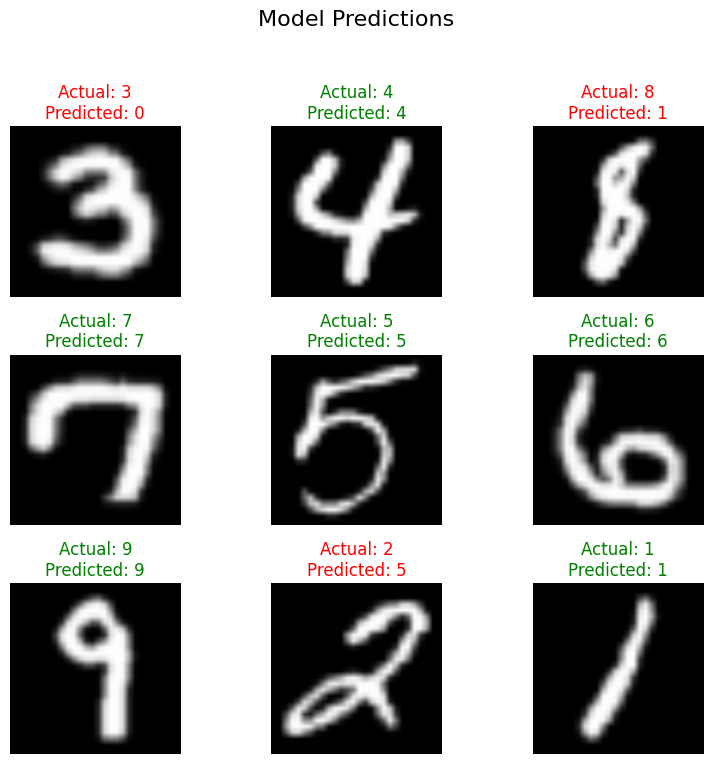

In [26]:
### Uncomment and execute the line below if you wish to visualize predictions

# Visualize the model's predictions on the validation images
helper_utils.show_predictions(fine_tune_trained_model, val_loader, device, emnist_class_names)

<br>

You have seen how to freeze the entire backbone and how to fine-tune just the top layers. The final strategy gives you complete control by allowing the entire model to adapt to your new dataset.

### Strategy 3: Full Retraining (Train the Entire Model)

This is the most computationally intensive approach and is essentially a continuation of fine-tuning. After replacing the classifier head, you unfreeze **all** layers in the backbone and retrain the entire model end to end on your new data. This strategy is most effective when you have a large dataset and want to adapt every pre-trained parameter to the specific patterns of your new task.

For full retraining, the entire model must be trainable. When you load a pre-trained model and replace its classifier head, **all layers are in a trainable state by default**. You only need to freeze layers if you specifically choose to, as you did in Strategies 1 and 2.

Since you are continuing with the model from the previous fine-tuning stage, which still has frozen layers, you must first unfreeze the entire backbone. 

* You'll iterate through all of the model's parameters and set their `requires_grad` attribute back to `True`, ensuring the entire model will be updated during training.

In [27]:
# The model from the previous fine-tuning stage
full_retrain_model = fine_tune_trained_model

# Unfreeze all parameters in the model
for param in full_retrain_model.parameters():
    param.requires_grad = True

* As a quick check, you can verify that a parameter from an early layer, which was previously frozen, is now trainable and ready for updates.

In [28]:
# Verify that an early layer is now unfrozen and trainable
print(f"Parameters in features[0] are unfrozen: {full_retrain_model.features[0][0].weight.requires_grad}")

Parameters in features[0] are unfrozen: True


#### Full Training

* For this final stage, you will create another optimizer. Unlike the previous stages where you selectively passed only the trainable parameters to the optimizer, this time you will pass `full_retrain_model.parameters()`. This simple change instructs the optimizer to calculate gradients and update the weights for **every single parameter** in the entire model, which is the core of the full retraining strategy.

In [29]:
# The optimizer now targets all parameters in the model
optimizer = torch.optim.SGD(
    full_retrain_model.parameters(),
    lr=1e-4
)


* Finally, pass all the components to the `training_loop` function to start the final stage of training.
    * During this process, the gradients will flow through and update the weights of **every single layer**, adapting the entire model from the earliest feature detectors to the final classifier head for your new task.

In [30]:
# Number of epochs for the full retraining stage
num_epochs_full_retrain = 1

# Continue training the entire model
final_model = helper_utils.training_loop(
    model=full_retrain_model,
    trainloader=train_loader,
    valloader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs_full_retrain,
    device=device
)

Epoch 1/1 [Train]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]


Finished Training!
Final Validation Accuracy: 0.8680


<br>

After this final training stage, you may see another boost in validation accuracy, potentially achieving the best performance of all three strategies. This stage was also the most computationally intensive; with every layer unfrozen, the optimizer had to calculate gradients and update weights for the entire model.

This highlights the core trade off of the full retraining approach. By investing the maximum amount of computation, you give the model complete freedom to adapt its entire learned representation to your new dataset, which can unlock the highest level of accuracy for complex tasks.

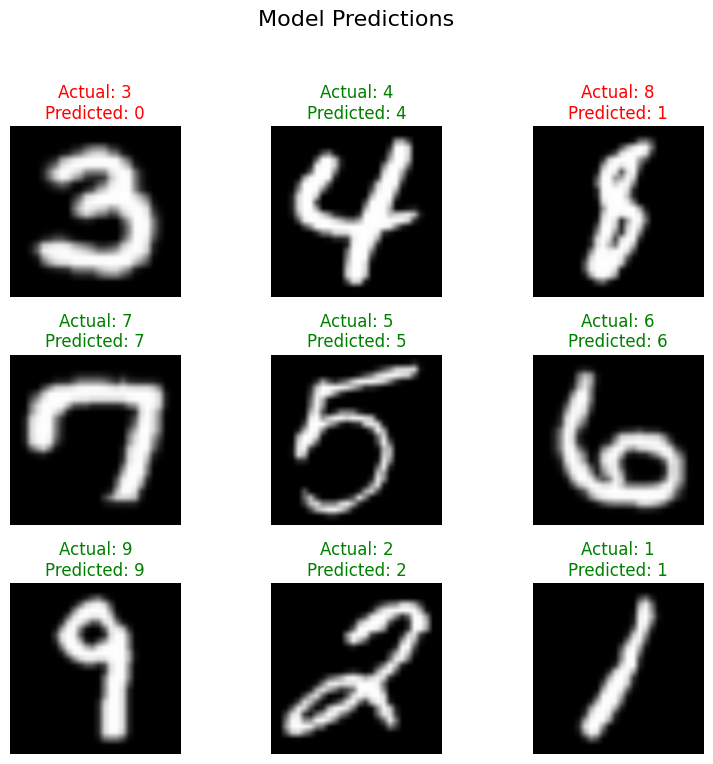

In [31]:
### Uncomment and execute the line below if you wish to visualize predictions

# Visualize the model's predictions on the validation images
helper_utils.show_predictions(final_model, val_loader, device, emnist_class_names)

<br>

Remember, the goal of demonstration of these different stategies was not to declare one strategy superior to another. Instead, view these three approaches, feature extraction, fine-tuning, and full retraining, as powerful and distinct tools in your professional toolkit. The best choice always depends on the unique demands of your project, including dataset size, available computing power, and performance requirements. You are now equipped to make that strategic decision and apply the right technique to your own work.

## Conclusion

You have successfully navigated the complete workflow of adapting a pre-trained model for a custom task. Starting with a model that produced nonsensical predictions, you applied a series of increasingly powerful techniques to teach it a new skill. You have not only learned the theory but have now implemented the three primary strategies in transfer learning. You started with **feature extraction**, the fastest method, by freezing the backbone and training only a new classifier head. Then, you moved to **fine-tuning**, a balanced approach where you unfroze and carefully trained the top layers of the backbone for a boost in performance. Finally, you explored **full retraining**, the most computationally intensive strategy, which allows the entire model to adapt to the new data.

The journey through these strategies demonstrates an essential lesson: there is no single "best" approach. Your choice will always depend on the unique demands of your project. For a small dataset or quick prototyping, feature extraction is an excellent starting point. When performance is paramount and you have sufficient data, fine-tuning or full retraining are more suitable options. You are now equipped with a versatile and powerful toolkit, ready to make strategic decisions and effectively apply transfer learning to your own computer vision challenges.